In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
train_data=pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test_data=pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')


In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Load dataset
home_data = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
X = home_data.drop("SalePrice", axis=1)
y = home_data.SalePrice

# Select numeric and categorical features
categorical_features = [c for c in X.columns if X[c].nunique() < 10 and X[c].dtype == "object"]
numeric_features = [c for c in X.columns if X[c].dtype in ['int64', 'float64']]

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
all_folds_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    train_X, val_X = X.iloc[train_idx], X.iloc[val_idx]
    train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=1, n_estimators=200, max_depth=12, min_samples_leaf=3, n_jobs=-1))
    ])
    
    model.fit(train_X, train_y)
    pred_train, pred_val = model.predict(train_X), model.predict(val_X)

    metrics = {
        "Train MAE": mean_absolute_error(train_y, pred_train),
        "Validation MAE": mean_absolute_error(val_y, pred_val),
        "Train MSE": mean_squared_error(train_y, pred_train),
        "Validation MSE": mean_squared_error(val_y, pred_val),
        "Train RMSE": np.sqrt(mean_squared_error(train_y, pred_train)),
        "Validation RMSE": np.sqrt(mean_squared_error(val_y, pred_val)),
        "Train RMSLE": np.sqrt(mean_squared_error(np.log1p(train_y), np.log1p(np.maximum(pred_train, 0)))),
        "Validation RMSLE": np.sqrt(mean_squared_error(np.log1p(val_y), np.log1p(np.maximum(pred_val, 0)))),
        "Train MAPE (%)": np.mean(np.abs((train_y - pred_train) / train_y)) * 100,
        "Validation MAPE (%)": np.mean(np.abs((val_y - pred_val) / val_y)) * 100,
        "Train R²": r2_score(train_y, pred_train),
        "Validation R²": r2_score(val_y, pred_val),
        "Train Median AE": median_absolute_error(train_y, pred_train),
        "Validation Median AE": median_absolute_error(val_y, pred_val)
    }

    all_folds_metrics.append(metrics)

# Convert to DataFrame
Error_df = pd.DataFrame(all_folds_metrics, index=[f"Fold {i}" for i in range(1, 6)])
Error_df.index.name = "Fold"

# ==== Add Average Row ====
avg_row = Error_df.astype(float).mean()
avg_row.name = "Average"
Error_df = pd.concat([Error_df, avg_row.to_frame().T])

# ==== Format Numbers ====
def format_number(x):
    if isinstance(x, (int, float, np.number)):
        return f"{x:.2e}" if abs(x) >= 1e5 else f"{x:.2f}"
    return x

Error_df = Error_df.map(format_number)

# ==== Display ====
print("\n========= Cross-Validation Regression Metrics =========")
display(Error_df)



========= Cross-Validation Regression Metrics =========


,Train MAE,Validation MAE,Train MSE,Validation MSE,Train RMSE,Validation RMSE,Train RMSLE,Validation RMSLE,Train MAPE (%),Validation MAPE (%),Train R²,Validation R²,Train Median AE,Validation Median AE
Fold 1,8990.88,17292.54,2.90e+08,9.59e+08,17039.49,30969.56,0.08,0.15,5.21,10.62,0.95,0.87,5301.07,11316.53
Fold 2,8899.53,18770.34,2.64e+08,1.01e+09,16236.66,31849.08,0.08,0.18,5.09,12.38,0.96,0.83,5008.64,13103.87
Fold 3,8781.18,18679.07,2.72e+08,8.64e+08,16498.75,29392.78,0.08,0.14,5.22,10.16,0.96,0.85,5272.51,10999.83
Fold 4,8564.61,18579.01,2.28e+08,1.33e+09,15103.95,36534.01,0.08,0.14,5.18,9.85,0.96,0.80,5239.87,9594.08
Fold 5,8968.85,15374.50,2.73e+08,5.44e+08,16532.82,23329.99,0.08,0.12,5.31,8.98,0.96,0.90,5375.23,10480.19
Average,8841.01,17739.09,2.66e+08,9.43e+08,16282.33,30415.08,0.08,0.15,5.20,10.40,0.96,0.85,5239.47,11098.90


In [4]:
Error_df.to_csv("/kaggle/working/Error.csv")

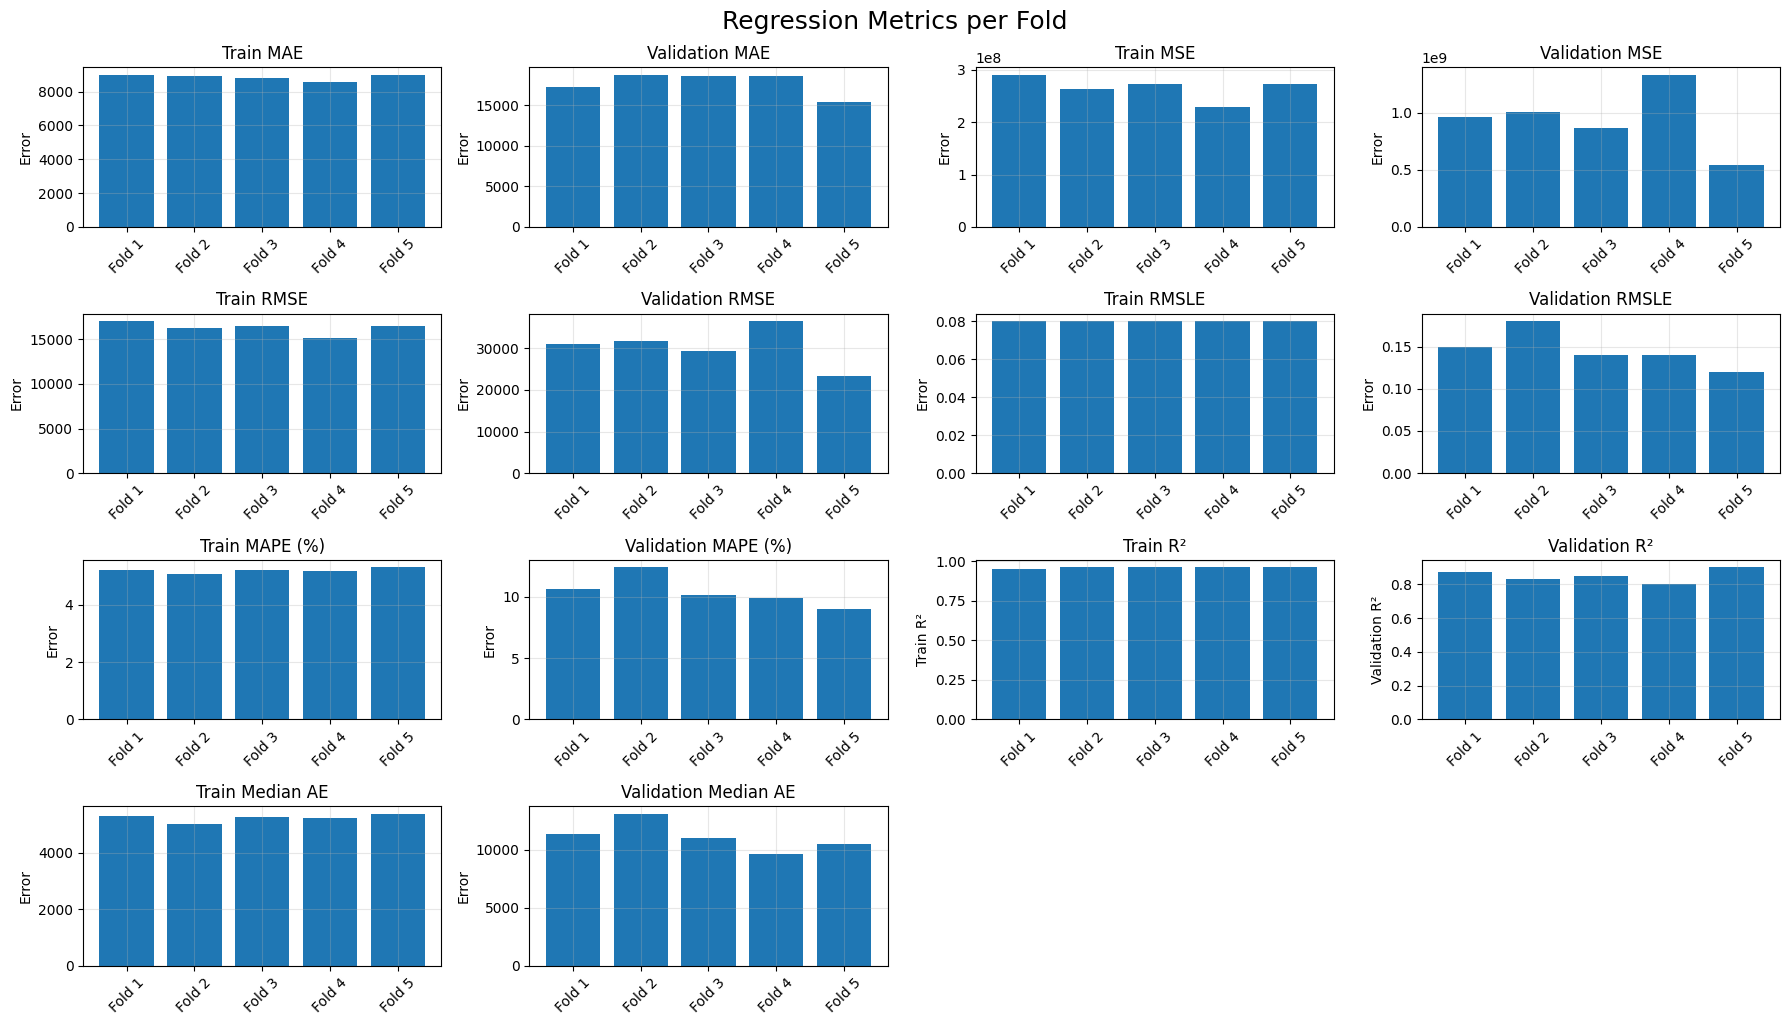

In [5]:
import matplotlib.pyplot as plt

# Convert numeric columns back to float for plotting (exclude Average row)
plot_df = Error_df.drop("Average").astype(float)

# List of metrics to plot
metrics = [
    "Train MAE", "Validation MAE",
    "Train MSE", "Validation MSE",
    "Train RMSE", "Validation RMSE",
    "Train RMSLE", "Validation RMSLE",
    "Train MAPE (%)", "Validation MAPE (%)",
    "Train R²", "Validation R²",
    "Train Median AE", "Validation Median AE"
]

# Plot
plt.figure(figsize=(18, 10))

for i, metric in enumerate(metrics):
    plt.subplot(4, 4, i+1)  # 4 rows x 4 columns subplot grid
    plt.bar(plot_df.index, plot_df[metric], color="#1f77b4")
    plt.xticks(rotation=45)
    plt.title(metric)
    plt.ylabel(metric if "R²" in metric else "Error")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Regression Metrics per Fold", fontsize=18, y=1.02)

# ---- Save the plot ----
# Change the filename or format as needed: 'Regression_Metrics.png', 'Regression_Metrics.pdf', etc.
plt.savefig("/kaggle/working/Regression_Metrics.png", dpi=300, bbox_inches='tight')

plt.show()


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=1, n_estimators=200, 
                                            max_depth=12, min_samples_leaf=3, n_jobs=-1))
    ])

# ==== Step 1: Define class conversion thresholds ====
p20, p40, p60, p80 = np.percentile(y, [20, 40, 60, 80])
class_labels = ["Too Low", "Low", "Medium", "High", "So High"]

def price_to_class(prices):
    classes = np.zeros_like(prices, dtype=int)
    classes[(prices >= p20) & (prices < p40)] = 1
    classes[(prices >= p40) & (prices < p60)] = 2
    classes[(prices >= p60) & (prices < p80)] = 3
    classes[(prices >= p80)] = 4
    return classes

# ==== Step 2: Cross-validation ====
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    train_X, val_X = X.iloc[train_idx], X.iloc[val_idx]
    train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]


    model.fit(train_X, train_y)
    
    # Predictions
    pred_train = model.predict(train_X)
    pred_val = model.predict(val_X)

    # Convert regression to class categories
    train_y_class, val_y_class = price_to_class(train_y), price_to_class(val_y)
    pred_train_class, pred_val_class = price_to_class(pred_train), price_to_class(pred_val)

    # Accuracy
    train_acc = accuracy_score(train_y_class, pred_train_class) * 100
    val_acc = accuracy_score(val_y_class, pred_val_class) * 100
    val_accuracies.append(val_acc)

    # Confusion matrix
    cm = confusion_matrix(val_y_class, pred_val_class)
    cm_df = pd.DataFrame(cm, index=[f"Actual {lbl}" for lbl in class_labels],
                            columns=[f"Pred {lbl}" for lbl in class_labels])

    # Per-class metrics
    precision = precision_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100
    recall = recall_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100
    f1 = f1_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100

    Performance_df = pd.DataFrame({
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1
    } , index = [x for x in class_labels])
    Performance_df.index.name = "Class"


    Performance_df = Performance_df.map(lambda x: f"{x:.2f}" if isinstance(x, (int, float,np.number)) else x)
    Performance_df = Performance_df.apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float,np.number)) else x)

    # ==== Step 3: Display results per fold ====
    print(f"\n================ Fold {fold} Results ================")
    print(f"Training Accuracy: {train_acc:.2f}%")
    print(f"Validation Accuracy: {val_acc:.2f}%\n")

    print("Confusion Matrix:")
    display(cm_df)

    print("\nClassification Metrics per Class:\n")
    display(Performance_df)

# ==== Step 4: Print Average Validation Accuracy ====
print(f"\nAverage Validation Accuracy: {np.mean(val_accuracies):.2f}%")



================ Fold 1 Results ================
Training Accuracy: 85.45%
Validation Accuracy: 68.49%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,50,22,0,0,0
Actual Low,13,35,9,1,0
Actual Medium,0,10,40,10,0
Actual High,0,1,15,28,5
Actual So High,0,0,0,6,47



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,79.37,69.44,74.07
Low,51.47,60.34,55.56
Medium,62.50,66.67,64.52
High,62.22,57.14,59.57
So High,90.38,88.68,89.52



================ Fold 2 Results ================
Training Accuracy: 85.87%
Validation Accuracy: 68.84%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,41,13,2,1,1
Actual Low,8,38,15,1,0
Actual Medium,0,8,32,11,1
Actual High,0,0,12,35,8
Actual So High,0,0,0,10,55



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,83.67,70.69,76.64
Low,64.41,61.29,62.81
Medium,52.46,61.54,56.64
High,60.34,63.64,61.95
So High,84.62,84.62,84.62



================ Fold 3 Results ================
Training Accuracy: 85.36%
Validation Accuracy: 72.26%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,40,8,2,0,0
Actual Low,8,37,8,0,0
Actual Medium,0,15,38,9,2
Actual High,0,0,11,45,6
Actual So High,0,0,1,11,51



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,83.33,80.00,81.63
Low,61.67,69.81,65.49
Medium,63.33,59.38,61.29
High,69.23,72.58,70.87
So High,86.44,80.95,83.61



================ Fold 4 Results ================
Training Accuracy: 86.04%
Validation Accuracy: 71.23%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,42,8,3,0,0
Actual Low,5,42,12,2,0
Actual Medium,1,21,30,9,0
Actual High,0,0,8,48,4
Actual So High,0,0,2,9,46



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,87.50,79.25,83.17
Low,59.15,68.85,63.64
Medium,54.55,49.18,51.72
High,70.59,80.00,75.00
So High,92.00,80.70,85.98



================ Fold 5 Results ================
Training Accuracy: 85.87%
Validation Accuracy: 72.60%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,46,9,1,0,0
Actual Low,5,36,14,2,0
Actual Medium,0,10,40,9,0
Actual High,0,0,13,41,7
Actual So High,0,0,0,10,49



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,90.20,82.14,85.98
Low,65.45,63.16,64.29
Medium,58.82,67.80,62.99
High,66.13,67.21,66.67
So High,87.50,83.05,85.22



Average Validation Accuracy: 70.68%


In [7]:
model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=1, n_estimators=200, max_depth=12,
                                            min_samples_leaf=3, n_jobs=-1))
    ])

# Class thresholds
p20, p40, p60, p80 = np.percentile(y, [20, 40, 60, 80])
class_labels = ["Too Low", "Low", "Medium", "High", "So High"]

def price_to_class(prices):
    classes = np.zeros_like(prices, dtype=int)
    classes[(prices >= p20) & (prices < p40)] = 1
    classes[(prices >= p40) & (prices < p60)] = 2
    classes[(prices >= p60) & (prices < p80)] = 3
    classes[(prices >= p80)] = 4
    return classes

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store metrics
fold_class_metrics = []
fold_accuracy = []
fold_confusion = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    train_X, val_X = X.iloc[train_idx], X.iloc[val_idx]
    train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]


    model.fit(train_X, train_y)
    pred_train, pred_val = model.predict(train_X), model.predict(val_X)

    # Class conversion
    train_y_class, val_y_class = price_to_class(train_y), price_to_class(val_y)
    pred_train_class, pred_val_class = price_to_class(pred_train), price_to_class(pred_val)

    # Accuracy per fold
    train_acc = accuracy_score(train_y_class, pred_train_class) * 100
    val_acc = accuracy_score(val_y_class, pred_val_class) * 100
    fold_accuracy.append({"Fold": fold, "Training Accuracy (%)": train_acc, "Validation Accuracy (%)": val_acc})

    # Class metrics
    precision = precision_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100
    recall = recall_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100
    f1 = f1_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100

    class_metrics_df = pd.DataFrame({
        "Fold": fold,
        "Class": class_labels,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1
    })
    fold_class_metrics.append(class_metrics_df)

    # Confusion matrix
    cm = confusion_matrix(val_y_class, pred_val_class)
    cm_df = pd.DataFrame(cm, index=[f"Actual {lbl}" for lbl in class_labels],
                         columns=[f"Pred {lbl}" for lbl in class_labels])
    cm_df.insert(0, "Fold", fold)
    cm_df = cm_df.reset_index().rename(columns={"index": "Actual Class"})
    fold_confusion.append(cm_df)

# ===== Combine DataFrames =====
# Class metrics
Performance_df = pd.concat(fold_class_metrics, ignore_index=True)
avg_metrics = Performance_df.groupby("Class")[["Precision (%)", "Recall (%)", "F1-Score (%)"]].mean().reset_index()
avg_metrics.insert(0, "Fold", "Average")
Performance_df = pd.concat([Performance_df, avg_metrics], ignore_index=True)
Performance_df[["Precision (%)", "Recall (%)", "F1-Score (%)"]] = \
    Performance_df[["Precision (%)", "Recall (%)", "F1-Score (%)"]].map(lambda x: f"{x:.2f}" if isinstance(x,(int,float,np.number)) else x)

# Accuracy metrics
Accuracy_df = pd.DataFrame(fold_accuracy)
avg_acc = Accuracy_df[["Training Accuracy (%)","Validation Accuracy (%)"]].mean()
avg_acc_row = {"Fold":"Average","Training Accuracy (%)":avg_acc["Training Accuracy (%)"],"Validation Accuracy (%)":avg_acc["Validation Accuracy (%)"]}
Accuracy_df = pd.concat([Accuracy_df, pd.DataFrame([avg_acc_row])], ignore_index=True)
Accuracy_df[["Training Accuracy (%)","Validation Accuracy (%)"]] = Accuracy_df[["Training Accuracy (%)","Validation Accuracy (%)"]].map(lambda x: f"{x:.2f}" if isinstance(x,(int,float,np.number)) else x)

# Confusion matrix for all folds
Confusion_df = pd.concat(fold_confusion, ignore_index=True)

# ===== Display =====
print("\n=== Confusion Matrices Per Fold ===")
display(Confusion_df)

print("=== Per-Class Metrics Across Folds ===")
display(Performance_df)

print("\n=== Training & Validation Accuracy Per Fold ===")
display(Accuracy_df)



# Optional: Save CSVs
# Performance_df.to_csv("/kaggle/working/Performance_PerClass.csv", index=False)
# Accuracy_df.to_csv("/kaggle/working/Accuracy_PerFold.csv", index=False)
#Confusion_df.to_csv("/kaggle/working/Confusion_PerFold.csv", index=False)



=== Confusion Matrices Per Fold ===


,Actual Class,Fold,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
0,Actual Too Low,1,50,22,0,0,0
1,Actual Low,1,13,35,9,1,0
2,Actual Medium,1,0,10,40,10,0
3,Actual High,1,0,1,15,28,5
4,Actual So High,1,0,0,0,6,47
5,Actual Too Low,2,41,13,2,1,1
6,Actual Low,2,8,38,15,1,0
7,Actual Medium,2,0,8,32,11,1
8,Actual High,2,0,0,12,35,8
9,Actual So High,2,0,0,0,10,55


=== Per-Class Metrics Across Folds ===


,Fold,Class,Precision (%),Recall (%),F1-Score (%)
0,1,Too Low,79.37,69.44,74.07
1,1,Low,51.47,60.34,55.56
2,1,Medium,62.50,66.67,64.52
3,1,High,62.22,57.14,59.57
4,1,So High,90.38,88.68,89.52
5,2,Too Low,83.67,70.69,76.64
6,2,Low,64.41,61.29,62.81
7,2,Medium,52.46,61.54,56.64
8,2,High,60.34,63.64,61.95
9,2,So High,84.62,84.62,84.62



=== Training & Validation Accuracy Per Fold ===


,Fold,Training Accuracy (%),Validation Accuracy (%)
0,1,85.45,68.49
1,2,85.87,68.84
2,3,85.36,72.26
3,4,86.04,71.23
4,5,85.87,72.60
5,Average,85.72,70.68


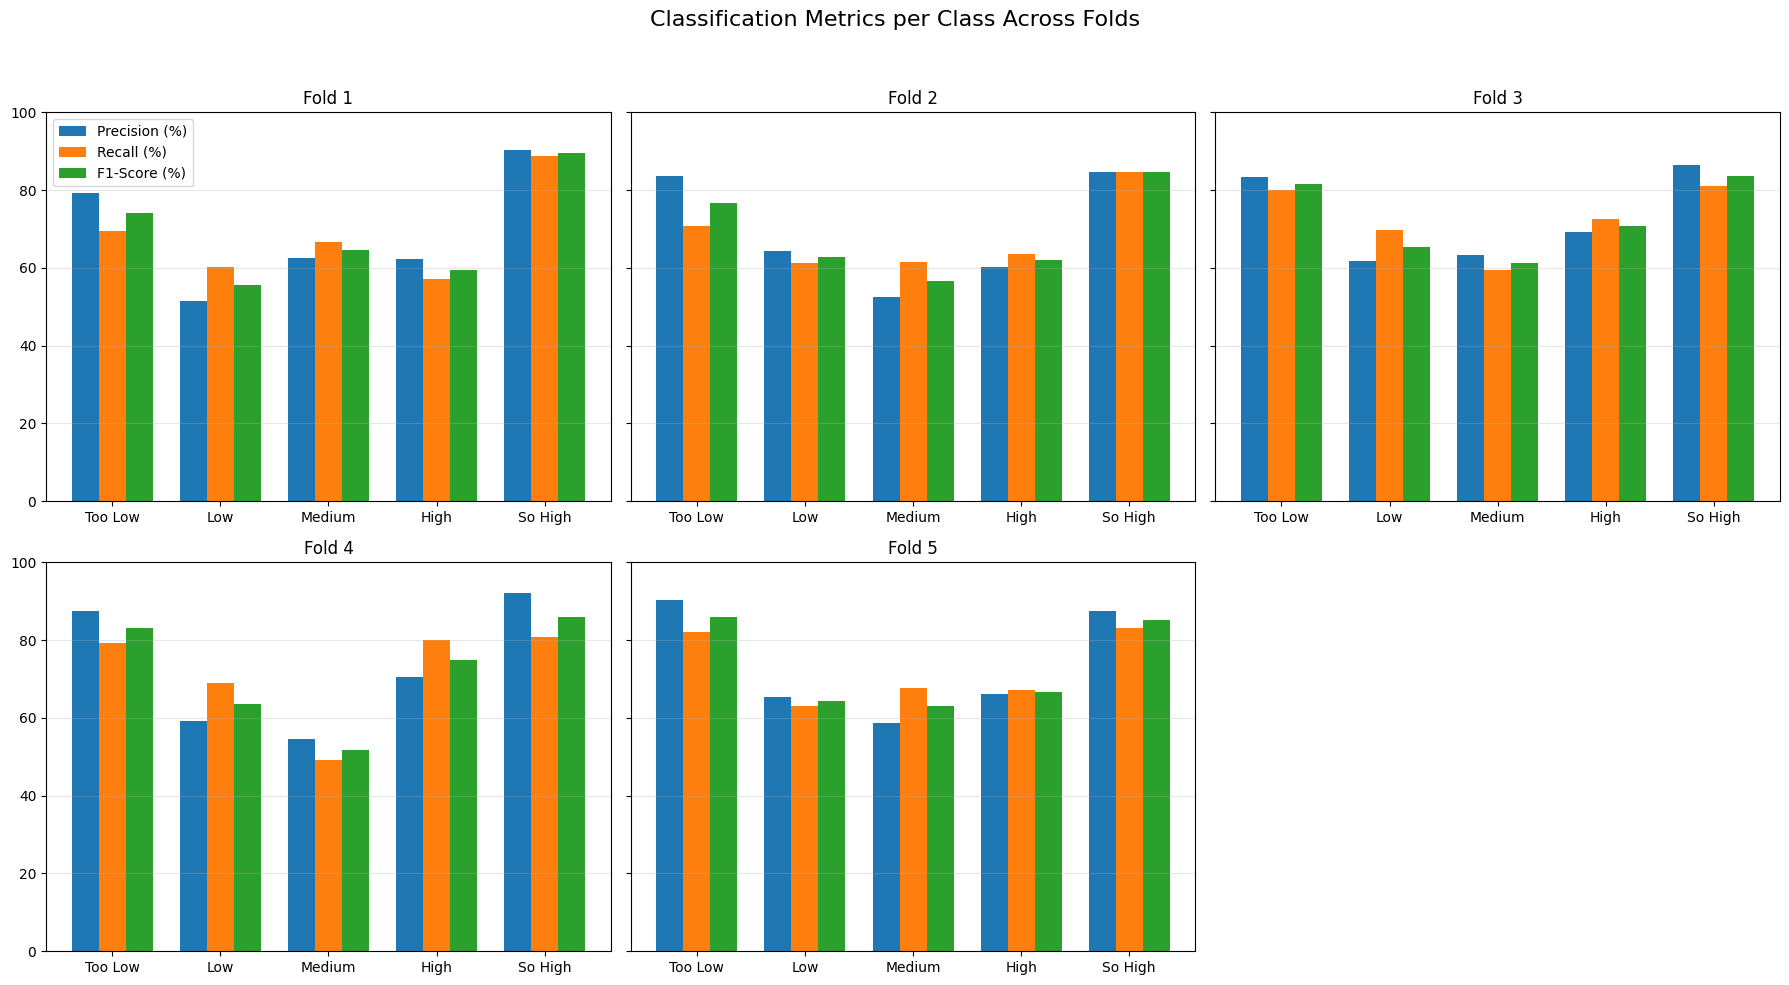

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
plot_df = Performance_df[Performance_df["Fold"] != "Average"].copy()
plot_df[["Precision (%)","Recall (%)","F1-Score (%)"]] = \
    plot_df[["Precision (%)","Recall (%)","F1-Score (%)"]].astype(float)

folds = sorted(plot_df["Fold"].unique())
classes = ["Too Low", "Low", "Medium", "High", "So High"]
metrics = ["Precision (%)", "Recall (%)", "F1-Score (%)"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18,10), sharey=True)
axes = axes.flatten()

for i, fold in enumerate(folds):
    ax = axes[i]
    fold_data = plot_df[plot_df["Fold"] == fold]
    x = np.arange(len(classes))
    
    for j, metric in enumerate(metrics):
        ax.bar(x + j*0.25, fold_data[metric], width=0.25, color=colors[j], label=metric if i==0 else "")
    
    ax.set_title(f"Fold {fold}")
    ax.set_xticks(x + 0.25)
    ax.set_xticklabels(classes)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)
    if i==0:
        ax.legend()

# Remove empty subplot if folds < number of axes
for k in range(len(folds), len(axes)):
    fig.delaxes(axes[k])

fig.suptitle("Classification Metrics per Class Across Folds", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
plt.savefig("/kaggle/working/Performaance_per_plot.png", dpi=300)
plt.show()


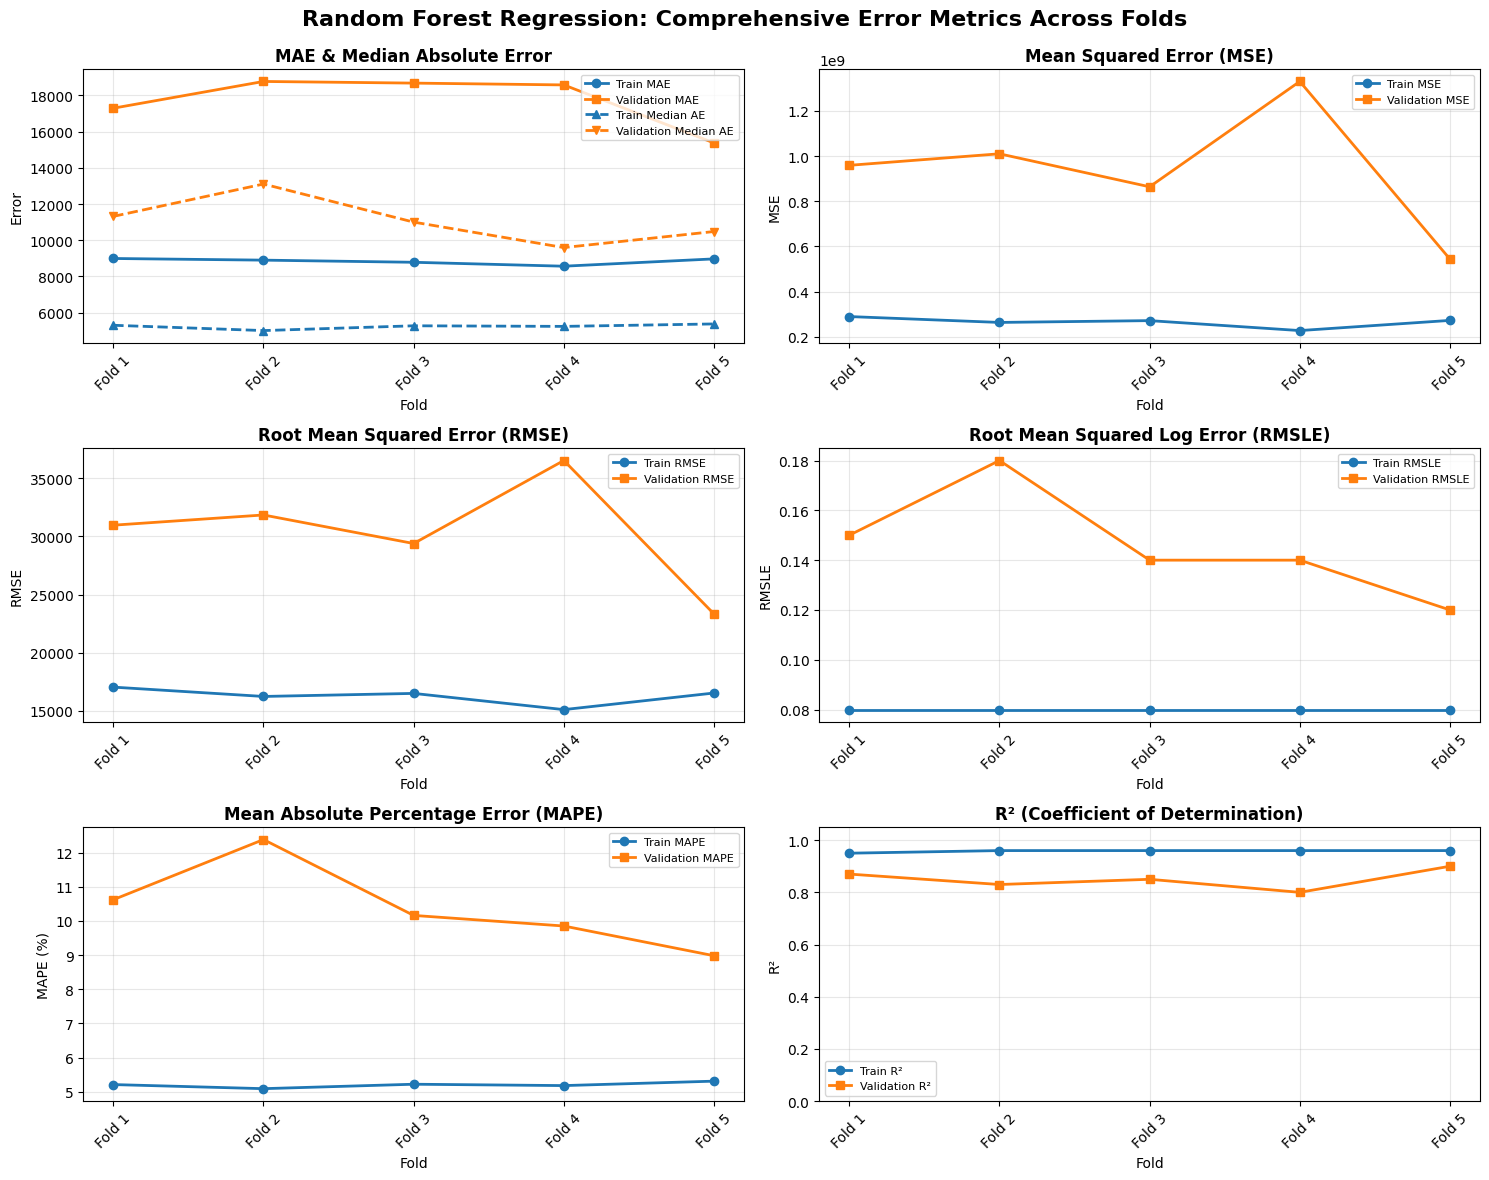

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Prepare Data for Plotting ===
Error_df_plot = Error_df.copy()

# Convert all numeric columns back to float
numeric_columns = [
    "Train MAE", "Validation MAE",
    "Train MSE", "Validation MSE",
    "Train RMSE", "Validation RMSE",
    "Train RMSLE", "Validation RMSLE",
    "Train MAPE (%)", "Validation MAPE (%)",
    "Train R²", "Validation R²",
    "Train Median AE", "Validation Median AE"
]

# Ensure numeric types for plotting
for col in numeric_columns:
    Error_df_plot[col] = pd.to_numeric(Error_df_plot[col], errors='coerce')

# Exclude Average row for fold-wise plotting
fold_df = Error_df_plot[Error_df_plot.index != "Average"]

# === Create Subplots: 3 rows x 2 columns ===
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# --- Plot 1: MAE & Median AE ---
axes[0].plot(fold_df.index, fold_df["Train MAE"], marker='o', label="Train MAE", color="#1f77b4", linewidth=2)
axes[0].plot(fold_df.index, fold_df["Validation MAE"], marker='s', label="Validation MAE", color="#ff7f0e", linewidth=2)
axes[0].plot(fold_df.index, fold_df["Train Median AE"], marker='^', linestyle='--', color="#1f77b4", linewidth=2, label="Train Median AE")
axes[0].plot(fold_df.index, fold_df["Validation Median AE"], marker='v', linestyle='--', color="#ff7f0e", linewidth=2, label="Validation Median AE")
axes[0].set_title("MAE & Median Absolute Error", fontsize=12, weight='bold')
axes[0].set_ylabel("Error")
axes[0].grid(alpha=0.3)
axes[0].legend(fontsize=8)

# --- Plot 2: MSE ---
axes[1].plot(fold_df.index, fold_df["Train MSE"], marker='o', label="Train MSE", color="#1f77b4", linewidth=2)
axes[1].plot(fold_df.index, fold_df["Validation MSE"], marker='s', label="Validation MSE", color="#ff7f0e", linewidth=2)
axes[1].set_title("Mean Squared Error (MSE)", fontsize=12, weight='bold')
axes[1].set_ylabel("MSE")
axes[1].grid(alpha=0.3)
axes[1].legend(fontsize=8)

# --- Plot 3: RMSE ---
axes[2].plot(fold_df.index, fold_df["Train RMSE"], marker='o', label="Train RMSE", color="#1f77b4", linewidth=2)
axes[2].plot(fold_df.index, fold_df["Validation RMSE"], marker='s', label="Validation RMSE", color="#ff7f0e", linewidth=2)
axes[2].set_title("Root Mean Squared Error (RMSE)", fontsize=12, weight='bold')
axes[2].set_ylabel("RMSE")
axes[2].grid(alpha=0.3)
axes[2].legend(fontsize=8)

# --- Plot 4: RMSLE ---
axes[3].plot(fold_df.index, fold_df["Train RMSLE"], marker='o', label="Train RMSLE", color="#1f77b4", linewidth=2)
axes[3].plot(fold_df.index, fold_df["Validation RMSLE"], marker='s', label="Validation RMSLE", color="#ff7f0e", linewidth=2)
axes[3].set_title("Root Mean Squared Log Error (RMSLE)", fontsize=12, weight='bold')
axes[3].set_ylabel("RMSLE")
axes[3].grid(alpha=0.3)
axes[3].legend(fontsize=8)

# --- Plot 5: MAPE ---
axes[4].plot(fold_df.index, fold_df["Train MAPE (%)"], marker='o', label="Train MAPE", color="#1f77b4", linewidth=2)
axes[4].plot(fold_df.index, fold_df["Validation MAPE (%)"], marker='s', label="Validation MAPE", color="#ff7f0e", linewidth=2)
axes[4].set_title("Mean Absolute Percentage Error (MAPE)", fontsize=12, weight='bold')
axes[4].set_ylabel("MAPE (%)")
axes[4].grid(alpha=0.3)
axes[4].legend(fontsize=8)

# --- Plot 6: R² ---
axes[5].plot(fold_df.index, fold_df["Train R²"], marker='o', label="Train R²", color="#1f77b4", linewidth=2)
axes[5].plot(fold_df.index, fold_df["Validation R²"], marker='s', label="Validation R²", color="#ff7f0e", linewidth=2)
axes[5].set_title("R² (Coefficient of Determination)", fontsize=12, weight='bold')
axes[5].set_ylabel("R²")
axes[5].set_ylim(0, 1.05)
axes[5].grid(alpha=0.3)
axes[5].legend(fontsize=8)

# === Common Formatting ===
for ax in axes:
    ax.set_xlabel("Fold", fontsize=10)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Random Forest Regression: Comprehensive Error Metrics Across Folds", 
             fontsize=16, weight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.93)

# === Save Plot ===
plt.savefig("/kaggle/working/RandomForest_all_error_metrics_per_fold.png", dpi=300, bbox_inches='tight')

plt.show()
